In [1]:
import math
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

# Seeding
np.random.seed(42)


# Learning From Data

The following represents a simulation of the examples given in Learning From Data

In [2]:
np.random.seed(42) # Reset seed!

In [3]:
# Target Ground Truth Function
# f: [-1, 1] \mapsto \mathbb{R}

def f_true(x):
    # is x a single point?
    # range -1 to 1
    return np.sin(np.pi*x)

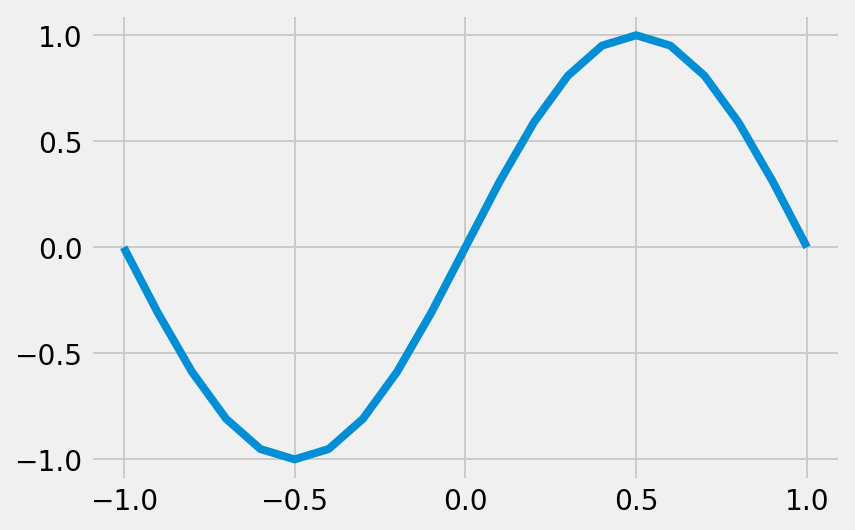

In [4]:
# Just a plot only
x = np.arange(-1,1.1,0.1)   # start,stop,step from -1 to 1 as prof restricted the domain

y = f_true(x)

plt.plot(x,y)
plt.show()

In [5]:
# we are given a dataset $\mathcal{D}$ with only two training examples.
# m = 2
# We have two hypothesis set, $\mathcal{H}_{0}, \mathcal{H}_{1}$ representing two models.

# $\mathcal{H}_{0}: h(x) = b$ set of all lines of the form $h(x) = b$
# $\mathcal{H}_{1}: h(x) = ax + b$ set of all lines of the form $h(x) = ax + b$
# Learning Algorithm for $\mathcal{H}_{0}$ is we choose $b = \dfrac{y_1 + y_2}{2}$, or more generally if we have m sample points, $b = \dfrac{y_1 + y_2 + ... + y_m}{m}$
# Learning Algorithm for $\mathcal{H}_{1}$ is we choose $a = \dfrac{y_2-y_1}{x_2-x_1}$ and $b = y_1 - a \cdot x_1$


def H_0(b, x=None):
    # h(x) = b so h is independent of our x :)
    return b


def H_1(x, a, b):
    # h(x) = ax + b
    return a * x + b


def A_0(y_1, y_2):
    b = (y_2 - y_1) / 2
    return b


def A_1(x_1, x_2, y_1, y_2):
    # slope
    a = (y_2 - y_1) / (x_2 - x_1)

    # intercept
    b = y_1 - a * x_1

    return a, b


# our $\mathcal{X}$ is the set of points generated in a uniform distribution from 0 to 1
# It thus follows that any sample X will be generated from this distribution
def generate_X(num_samples):

    # Prof says generate x uniformly from say 0 to 1
    # This is sampling from the whole domain (population)
    X = np.random.uniform(low=-1.0, high=1.0, size=num_samples)

    return X


# Take careful note that we are just generating X_test, Y_test from a fixed $\mathcal{D}$ now from the distribution.
# Always remember that we do not know f_true even though I am using it here. It is for illustration.
X_test = generate_X(num_samples=1)
Y_test = f_true(X_test)

print(X_test)
print(Y_test)

[-0.25091976]
[-0.70914702]


In [6]:
num_simulations = 3000
num_samples = 2


In [7]:

total_mse_H0 = 0

# This should hold all hypothesis we ran [h_1, h_2, ..., h_K], each hypothesis is based on a different D_i
H_0_list = []
# Hold the prediction for each h_i
H_0_pred = []

for sim in range(1, num_simulations+1):

    # Sample m data points from our population
    X_sampled = generate_X(num_samples = num_samples)

    # Find corresponding Y_sampled by calling the f_true function. We ignored the irreducible noise, if not need add epsilon which follows ~N(0,1)
    Y_sampled = f_true(X_sampled)
    

    #print(X_sampled, Y_sampled)

    # Unpack points as we are assuming 2 sample points. One can refactor to make it generalize to d-dimensional space
    x_1, x_2 = X_sampled
    y_1, y_2 = Y_sampled

    # Deploy our learning algorithm A_0 to learn h_1
    # Note in the first loop, our algorithm A_0 used D_1 = {X_sampled, Y_sampled} to learn
    # Note in the second loop, our algorithm A_0 used D_2 = {X_sampled, Y_sampled} to learn (this dataset is different from D_1)
    # Here is where we usually call .fit, but our model is just a constant so...
    b = A_0(y_1, y_2)

    # Make prediction on our x_q (X_test): Note we only use 1 single test point
    pred_H0 = H_0(b=b)
    
    # Note we only need our b for our different h's because our model is a constant b
    H_0_list.append(b)
    
    # Note that the prediction is just b
    H_0_pred.append(pred_H0)

    # mse for current simulation, for current h_i based on current D_i
    mse = ((Y_test - pred_H0) ** 2) / 1 # divide by 1 since only 1 query point; if not may need np.sum((Y_test-pred_H0)**2)/num_of_test_points

    total_mse_H0 += mse

# Expected Test Error is given as such
expected_mse_H0 = total_mse_H0 / num_simulations
print("Expected MSE/Generalization Error for H0", expected_mse_H0)

# The average hypothesis for H_0 through simulation is given by H_0(x) = h_bar_H0 which is the mean of all the b.
h_bar_H0 = np.mean(H_0_list, axis=None)
bias_H0 = (h_bar_H0 - Y_test)**2
print("Bias Squared for H0", bias_H0)

variance_H0 = np.sum((H_0_pred - h_bar_H0)**2) / num_simulations
print("Variance for H0", variance_H0)

print("Bias + Variance", bias_H0 + variance_H0)


Expected MSE/Generalization Error for H0 [0.75117865]
Bias Squared for H0 [0.49974302]
Variance for H0 0.25143562730954
Bias + Variance [0.75117865]


In [8]:
total_mse_H1 = 0

# This should hold all hypothesis we ran [h_1, h_2, ..., h_K], each hypothesis is based on a different D_i
# This time we have two degrees of parameters to keep track!
H_1_dict = {"slope": [], "intercept": []}
# Hold the prediction for each h_i
H_1_pred = []

for sim in range(1, num_simulations+1):

    # Sample m data points from our population
    X_sampled = generate_X(num_samples = num_samples)

    # Find corresponding Y_sampled by calling the f_true function. We ignored the irreducible noise, if not need add epsilon which follows ~N(0,1)
    Y_sampled = f_true(X_sampled)
    

    #print(X_sampled, Y_sampled)

    # Unpack points as we are assuming 2 sample points. One can refactor to make it generalize to d-dimensional space
    x_1, x_2 = X_sampled
    y_1, y_2 = Y_sampled

    # Deploy our learning algorithm A_0 to learn h_1
    # Note in the first loop, our algorithm A_0 used D_1 = {X_sampled, Y_sampled} to learn
    # Note in the second loop, our algorithm A_0 used D_2 = {X_sampled, Y_sampled} to learn (this dataset is different from D_1)
    # Here is where we usually call .fit, but our model is already just a line equation
    a, b =  A_1(x_1, x_2, y_1, y_2)

    # Make prediction on our x_q (X_test): Note we only use 1 single test point
    pred_H1 = H_1(X_test, a, b)
    
    # Note we only need our b for our different h's because our model is a constant b
    H_1_dict['slope'].append(a)
    H_1_dict['intercept'].append(b)
    
    # Note that the prediction is just b
    H_1_pred.append(pred_H1)

    # mse for current simulation, for current h_i based on current D_i
    mse = ((Y_test - pred_H1) ** 2) / 1 # divide by 1 since only 1 query point; if not may need np.sum((Y_test-pred_H0)**2)/num_of_test_points

    total_mse_H1 += mse

# Expected Test Error is given as such
expected_mse_H1 = total_mse_H1 / num_simulations
print("Expected MSE/Generalization Error for H1", expected_mse_H1)

# Find mean for a and b respectively to get our "average hypothesis"
mean_slope_a = np.mean(H_1_dict['slope'])
mean_intercept_b = np.mean(H_1_dict['intercept'])
h_bar_H1 = H_1(x=X_test, a=mean_slope_a, b=mean_intercept_b)
bias_H1 =  (h_bar_H1 - Y_test)**2
print("Bias Squared for H1", bias_H1)

variance_H1 = np.sum((H_1_pred - h_bar_H1)**2) / num_simulations
print(variance_H1)

print("Bias + Variance", bias_H1 + variance_H1)

Expected MSE/Generalization Error for H1 [1.28756503]
Bias Squared for H1 [0.24269493]
1.0448700937097741
Bias + Variance [1.28756503]


Notice that the Bias + Variance is almost equals to the Expected Test Error!!!